# Computations for Potential density, buoyancy and geostrophic shear

*contribution of Hemant Khatri.*

In [1]:
import xarray as xr
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

First load the usual MOM6 dataset with xarray:

In [2]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1})

In [3]:
print(ds)

<xarray.Dataset>
Dimensions:       (nv: 2, time: 60, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
Data variables:
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    Coriolis      

Next we create the xgcm Grid object:

In [4]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X']);

## Potential density

There are several python packages for computations using the Equation Of State (e.g. gsw, seawater, xgcm/fastjmd95). Here we need the Wright 97 EOS to stay consistent with MOM6 model. In this formulation, the potential density can be expressed by:

In [5]:
def pdens(S,theta):
    
    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464
    
    # To compute potential density keep pressure p = 100 kpa
    # S in standard salinity units psu, theta in DegC, p in pascals
    
    p = 100000.
    alpha0 = a0 + a1*theta + a2*S
    p0 = b0 + b1*theta + b2*theta**2 + b3*theta**3 + b4*S + b5*theta*S
    lambd = c0 + c1*theta + c2*theta**2 + c3*theta**3 + c4*S + c5*theta*S 
    
    pot_dens = (p + p0)/(lambd + alpha0*(p + p0))
    
    return pot_dens    

A naive approach to computing the potential density would be to pass our dataarrays directly to the function, i.e. 

If we use the function directly, the risk is that we will probably swith from lazy evaluation to eager. Instead we can wrap the function with apply_ufunc
and stay in a lazy evaluation mode:

In [6]:
pt = xr.apply_ufunc(pdens, ds.so, ds.thetao, 
                    dask='parallelized', 
                    output_dtypes=[ds.so.dtype])

print(pt)

<xarray.DataArray (time: 60, z_l: 35, yh: 576, xh: 720)>
dask.array<pdens, shape=(60, 35, 576, 720), dtype=float32, chunksize=(1, 1, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * time     (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00


You can verify that the evaluation was instantaneous (no computation made) and we can now compute (can also use pt.compute()) and plot for one level and one time slice with: 

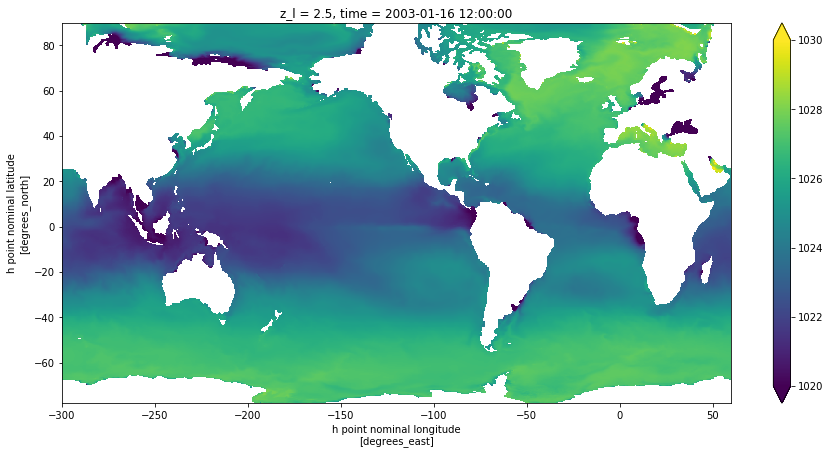

In [7]:
fig = plt.figure(figsize=(15,7))
pt.isel(z_l=0, time = 0).plot(vmin=1020, vmax=1030)

## Buoyancy

In order to compute buoyancy, we first define reference density = 1035 kg/m$^3$. Then we compute density anomaly as: 

In [8]:
rho_ref = 1035.
anom_density = pt - rho_ref

and buoyancy: 

$b = -g \frac{\rho'}{\rho_o}$

In [9]:
g = 9.81
buoyancy = -g * anom_density / rho_ref

In [10]:
buoyancy

<xarray.DataArray (time: 60, z_l: 35, yh: 576, xh: 720)>
dask.array<truediv, shape=(60, 35, 576, 720), dtype=float32, chunksize=(1, 1, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * time     (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00

## Geostrophic shear

First interpolate the Coriolis parameter onto U, V points:

In [11]:
f_U = grid.interp(ds.Coriolis, 'Y', boundary='fill')
f_V = grid.interp(ds.Coriolis, 'X', boundary='fill')

Then compute density gradients in the (x,y) direction. Those are then located also on (U, V) points:

In [12]:
ddens_dx = grid.diff(anom_density * ds.dyt, 'X', boundary='fill') / ds.areacello_cu
ddens_dy = grid.diff(anom_density * ds.dxt, 'Y', boundary='fill') / ds.areacello_cv

Finally the geostrophic shear can be expressed as:

$\frac{\partial u_g}{\partial z} = - \frac{\partial b'}{\partial y} = \frac{g}{f\rho_o}\frac{\partial \rho'}{\partial y} $

$\frac{\partial v_g}{\partial z} =  \frac{\partial b'}{\partial x} = - \frac{g}{f\rho_o}\frac{\partial \rho'}{\partial x} $

In [13]:
dz_ug =   ddens_dy * g / (f_V * rho_ref)
dz_vg = - ddens_dx * g / (f_U * rho_ref)

We can now look at the results. NB: this will trigger eager computation and may take some time to process even with a dask cluster.

In [14]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37774 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.22 GB


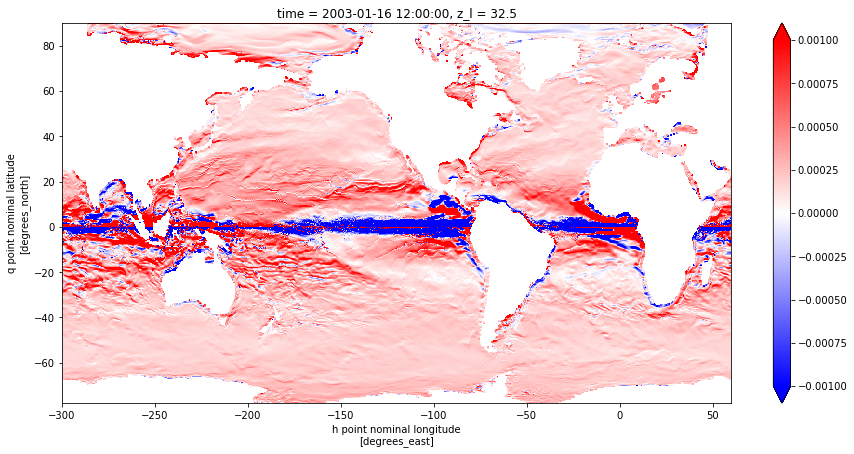

In [15]:
# Geostrophic Shear plot
tmp = dz_ug.isel({'z_l': slice(3,4), 'time' : slice(0,1)})

fig = plt.figure(figsize=(15,7))
tmp.plot(cmap = 'bwr', vmin = -.001, vmax = 0.001)